# MNIST dataset

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2
import joblib

from sklearn.datasets import fetch_openml

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

np.random.seed(42)

# Creating a function that will be used later

In [2]:
# def display_confusion_matrix(y_test, y_pred):
#     cm = confusion_matrix(y_test, y_pred)
#     ConfusionMatrixDisplay(cm).plot()

# Function to display confusion matrix with model name
def display_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")  # Set blue scale for the confusion matrix
    plt.title(f"Confusion Matrix for {model_name}")  # Add the model name to the title
    plt.show()

# Downloading the data and inspecting it

In [5]:
# Load dataset and explore
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False) #False meaning they are imported as NumpyArrays

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [6]:
print(X)
print(X.shape)
print(y)
print(y.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(70000, 784)
[5 0 4 ... 4 5 6]
(70000,)


In [9]:
## x: 70000 rader och 784 kolumner, kolumner består en gråskala från 0 till 255
## y: 70000 rader och en kolumn med siffror

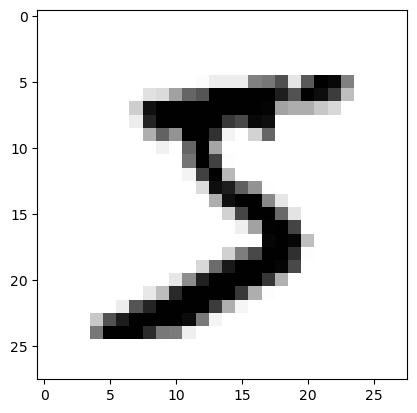

In [7]:
# Plotting the features of the X data, it looks like a 5.
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
# plt.axis("off")

In [41]:
# Load the MNIST dataset from OpenML - need to run as_frame=False for pandas
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

# Extract the features (X) and labels (y)
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

# Loop through digits 0 to 9 and print one example of each
for digit in range(10):
    # Find the index of the first occurrence of the current digit
    digit_index = np.where(y == digit)[0][0]
    
    # Get the 784-dimensional image of the digit (flattened 28x28)
    digit_image_flat = X.iloc[digit_index].to_numpy()
    
    # Reshape the flattened image into a 28x28 array
    digit_image = digit_image_flat.reshape(28, 28)
    
    # Print the pixel values of the 28x28 image
    print(f"28x28 Pixel Values of the Digit '{digit}':")
    for row in digit_image:
        print(" ".join([f"{int(val):3d}" for val in row]))  # Print each value with width 3 for better alignment
    
    # Plot the image
    plt.figure()
    plt.imshow(digit_image, cmap='gray')
    plt.title(f"Example of Digit {digit}")
    plt.axis('off')  # Remove axes for better visualization
    plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [8]:
# Split the dataset into training, validation and test set 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42)

# Standardizing the data for SVC/SVM
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

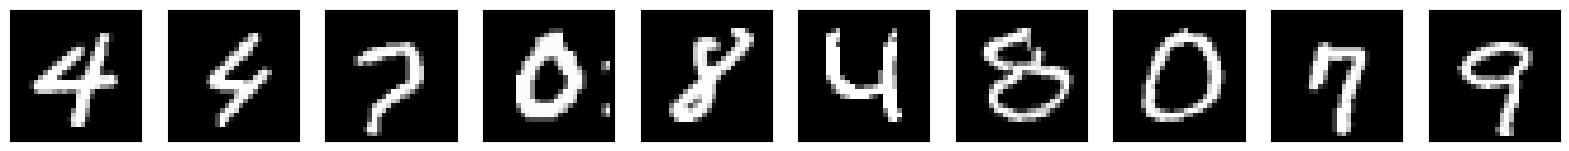

In [15]:
# Display the first 'n' images from the training set
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))  # Create a figure for the images

for i in range(n):
    ax = plt.subplot(2, n, i + 1)  # Create a subplot for each image
    plt.imshow(X_train[i].reshape(28, 28))  # Display the image
    plt.gray()  # Set the color map to grayscale
    ax.get_xaxis().set_visible(False)  # Hide the x-axis
    ax.get_yaxis().set_visible(False)  # Hide the y-axis

plt.show()  # Show the plot
plt.close()  # Close the plot

In [17]:
# Calculate the mean and standarddeviation of the X_train values
mean = np.mean(X_train_val)
std = np.std(X_train_val)

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

Mean: 33.41221292517007
Standard Deviation: 78.68341980486107


# Model selection - train and validate the data on five models
1. Random Forest Classifier
2. Extra Trees Classifier
3. Linear SVC
4. Logistic Regression
5. SVM

In [21]:
# manual iteration for best hyperparamater - should be replaced with gridsearch but takes a long time. 
log_regression = LogisticRegression(max_iter=1000, solver='lbfgs')
log_regression.fit(X_train_scaled, y_train) #fit on training set
score = log_regression.score(X_val_scaled, y_val)  # Directly compute accuracy
print(log_regression.__class__.__name__, score)

LogisticRegression 0.9099


In [19]:
# Create instances for each model
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_linear_clf = LinearSVC(max_iter=100, tol=2, random_state=42) #tol=20, 
log_regression = LogisticRegression(max_iter=1000, solver='lbfgs')
svm_clf = SVC(kernel="poly", degree=3, coef0=1, C=0.5)

In [26]:
# train each model on the training data and validate on the validation data (using scaled data)
for clf in (random_forest_clf, extra_trees_clf, svm_linear_clf, log_regression, svm_clf): #each model
    clf.fit(X_train_scaled, y_train) #fit on training set
    score = clf.score(X_val_scaled, y_val)  # Directly compute accuracy
    print(clf.__class__.__name__, score)

RandomForestClassifier 0.9692
ExtraTreesClassifier 0.9715
LinearSVC 0.8564
LogisticRegression 0.9099
SVC 0.973


In [27]:
# train each model on the training data and validate on the validation data (using unscaled data)
for clf in (random_forest_clf, extra_trees_clf, svm_linear_clf, log_regression, svm_clf): #each model
    clf.fit(X_train, y_train) #fit on training set
    score = clf.score(X_val, y_val)  # Directly compute accuracy
    print(clf.__class__.__name__, score)

RandomForestClassifier 0.9692
ExtraTreesClassifier 0.9715
LinearSVC 0.6889


C:\Users\bjorn\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression 0.9081
SVC 0.981


Model: RandomForestClassifier, Accuracy: 0.9692
Confusion Matrix:


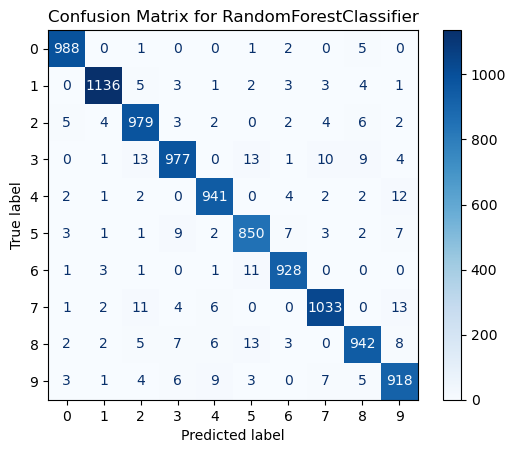

------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       997
           1       0.99      0.98      0.98      1158
           2       0.96      0.97      0.97      1007
           3       0.97      0.95      0.96      1028
           4       0.97      0.97      0.97       966
           5       0.95      0.96      0.96       885
           6       0.98      0.98      0.98       945
           7       0.97      0.97      0.97      1070
           8       0.97      0.95      0.96       988
           9       0.95      0.96      0.96       956

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

------------------------------------------------------------
Model: ExtraTreesClassifier, Accuracy: 0.9715
Confusion Matrix:


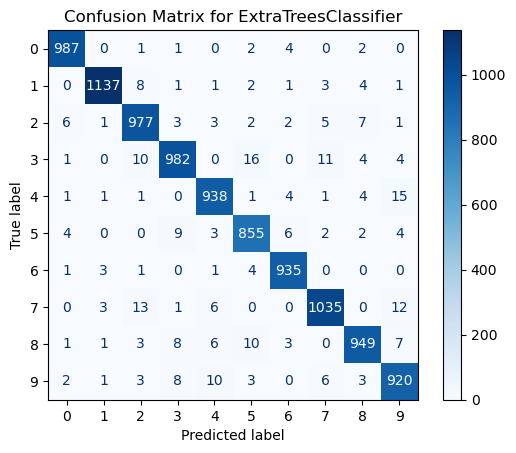

------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       997
           1       0.99      0.98      0.99      1158
           2       0.96      0.97      0.97      1007
           3       0.97      0.96      0.96      1028
           4       0.97      0.97      0.97       966
           5       0.96      0.97      0.96       885
           6       0.98      0.99      0.98       945
           7       0.97      0.97      0.97      1070
           8       0.97      0.96      0.97       988
           9       0.95      0.96      0.96       956

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

------------------------------------------------------------
Model: LinearSVC, Accuracy: 0.8564
Confusion Matrix:


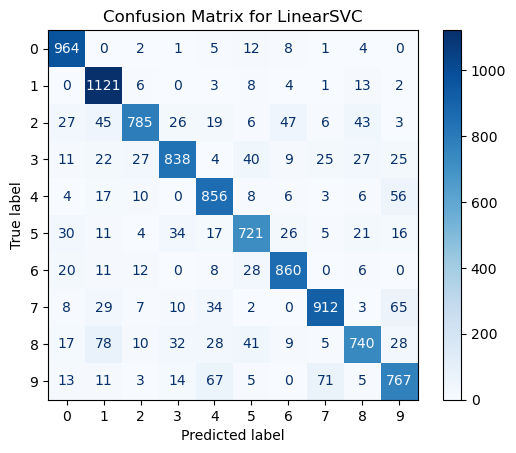

------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       997
           1       0.83      0.97      0.90      1158
           2       0.91      0.78      0.84      1007
           3       0.88      0.82      0.85      1028
           4       0.82      0.89      0.85       966
           5       0.83      0.81      0.82       885
           6       0.89      0.91      0.90       945
           7       0.89      0.85      0.87      1070
           8       0.85      0.75      0.80       988
           9       0.80      0.80      0.80       956

    accuracy                           0.86     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.86      0.86     10000

------------------------------------------------------------
Model: LogisticRegression, Accuracy: 0.9099
Confusion Matrix:


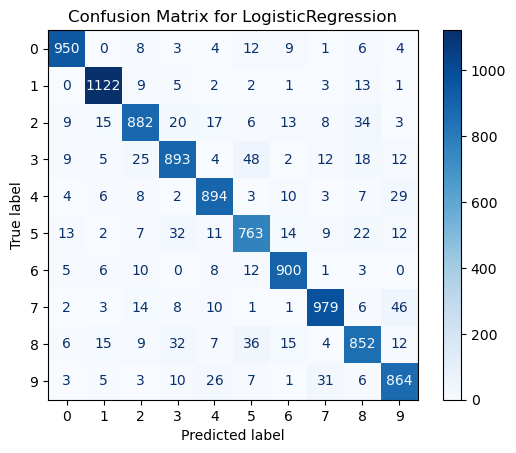

------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       997
           1       0.95      0.97      0.96      1158
           2       0.90      0.88      0.89      1007
           3       0.89      0.87      0.88      1028
           4       0.91      0.93      0.92       966
           5       0.86      0.86      0.86       885
           6       0.93      0.95      0.94       945
           7       0.93      0.91      0.92      1070
           8       0.88      0.86      0.87       988
           9       0.88      0.90      0.89       956

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

------------------------------------------------------------
Model: SVC, Accuracy: 0.9730
Confusion Matrix:


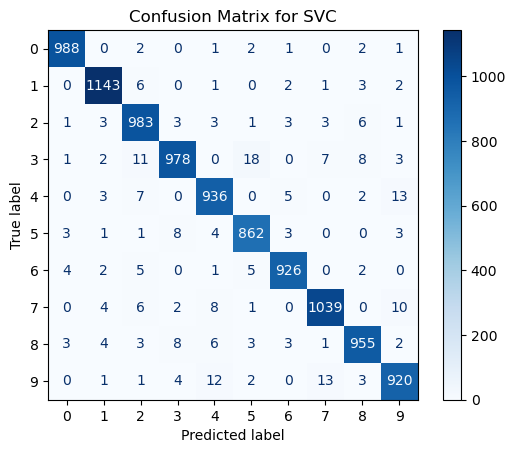

------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       997
           1       0.98      0.99      0.98      1158
           2       0.96      0.98      0.97      1007
           3       0.98      0.95      0.96      1028
           4       0.96      0.97      0.97       966
           5       0.96      0.97      0.97       885
           6       0.98      0.98      0.98       945
           7       0.98      0.97      0.97      1070
           8       0.97      0.97      0.97       988
           9       0.96      0.96      0.96       956

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

------------------------------------------------------------


In [30]:
# Train each model on the training data and validate on the validation data (using scaled data)
for clf in (random_forest_clf, extra_trees_clf, svm_linear_clf, log_regression, svm_clf): 
    # Fit the model
    clf.fit(X_train_scaled, y_train)  
    
    # Validate the model
    y_pred = clf.predict(X_val_scaled)  # Predicted labels
    score = clf.score(X_val_scaled, y_val)  # Compute accuracy
    
    # Print the model name and accuracy
    print(f"Model: {clf.__class__.__name__}, Accuracy: {score:.4f}")
    
    # Display the confusion matrix with the model name
    print("Confusion Matrix:")
    display_confusion_matrix(y_val, y_pred, clf.__class__.__name__)
    print("-" * 60)  # Separator for readability
    
    # Print the classification report
    print("Classification Report:")
    print(classification_report(y_val, y_pred))
    print("-" * 60)  # Separator for readability

## Voting classifier - Train and evaluate 5 models using the Voting Classifier model

Model: RandomForestClassifier, Accuracy: 0.9692
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       997
           1       0.99      0.98      0.98      1158
           2       0.96      0.97      0.97      1007
           3       0.97      0.95      0.96      1028
           4       0.97      0.97      0.97       966
           5       0.95      0.96      0.96       885
           6       0.98      0.98      0.98       945
           7       0.97      0.97      0.97      1070
           8       0.97      0.95      0.96       988
           9       0.95      0.96      0.96       956

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Confusion Matrix:


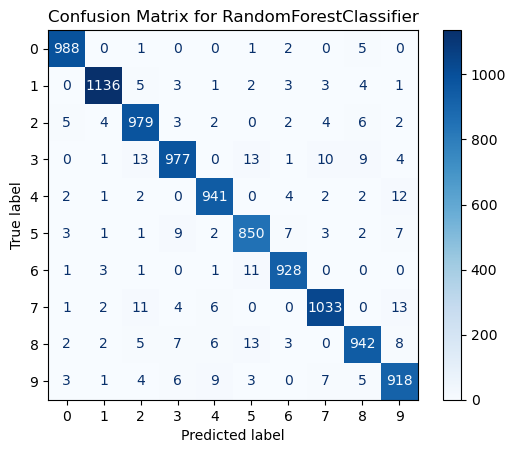

------------------------------------------------------------
Model: ExtraTreesClassifier, Accuracy: 0.9715
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       997
           1       0.99      0.98      0.99      1158
           2       0.96      0.97      0.97      1007
           3       0.97      0.96      0.96      1028
           4       0.97      0.97      0.97       966
           5       0.96      0.97      0.96       885
           6       0.98      0.99      0.98       945
           7       0.97      0.97      0.97      1070
           8       0.97      0.96      0.97       988
           9       0.95      0.96      0.96       956

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Confusion Matrix:


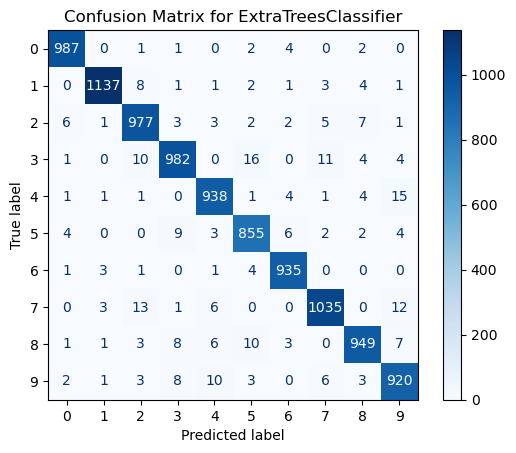

------------------------------------------------------------
Model: LinearSVC, Accuracy: 0.8564
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       997
           1       0.83      0.97      0.90      1158
           2       0.91      0.78      0.84      1007
           3       0.88      0.82      0.85      1028
           4       0.82      0.89      0.85       966
           5       0.83      0.81      0.82       885
           6       0.89      0.91      0.90       945
           7       0.89      0.85      0.87      1070
           8       0.85      0.75      0.80       988
           9       0.80      0.80      0.80       956

    accuracy                           0.86     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.86      0.86     10000

Confusion Matrix:


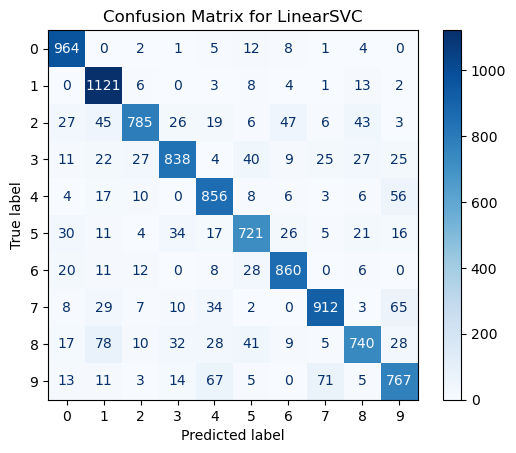

------------------------------------------------------------
Model: LogisticRegression, Accuracy: 0.9099
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       997
           1       0.95      0.97      0.96      1158
           2       0.90      0.88      0.89      1007
           3       0.89      0.87      0.88      1028
           4       0.91      0.93      0.92       966
           5       0.86      0.86      0.86       885
           6       0.93      0.95      0.94       945
           7       0.93      0.91      0.92      1070
           8       0.88      0.86      0.87       988
           9       0.88      0.90      0.89       956

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Confusion Matrix:


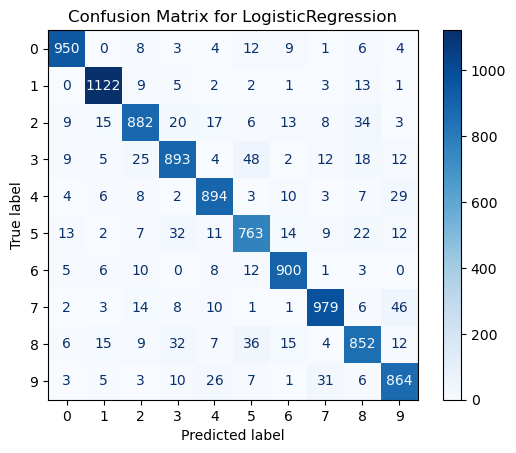

------------------------------------------------------------
Model: SVC, Accuracy: 0.9730
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       997
           1       0.98      0.99      0.98      1158
           2       0.96      0.98      0.97      1007
           3       0.98      0.95      0.96      1028
           4       0.96      0.97      0.97       966
           5       0.96      0.97      0.97       885
           6       0.98      0.98      0.98       945
           7       0.98      0.97      0.97      1070
           8       0.97      0.97      0.97       988
           9       0.96      0.96      0.96       956

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Confusion Matrix:


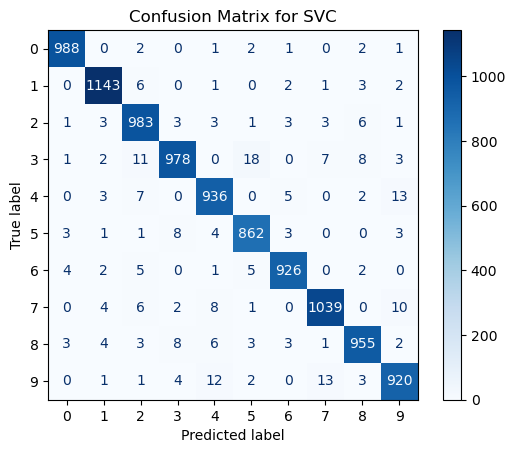

------------------------------------------------------------
Model: VotingClassifier, Accuracy: 0.9682
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       997
           1       0.99      0.99      0.99      1158
           2       0.95      0.97      0.96      1007
           3       0.97      0.95      0.96      1028
           4       0.96      0.98      0.97       966
           5       0.95      0.96      0.96       885
           6       0.98      0.98      0.98       945
           7       0.97      0.97      0.97      1070
           8       0.97      0.95      0.96       988
           9       0.96      0.95      0.96       956

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Confusion Matrix:


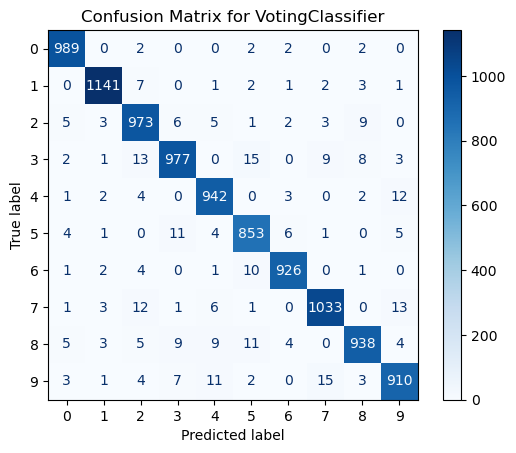

------------------------------------------------------------


In [36]:
# Train and evaluate 5 models using the Voting Classifer model (using scaled data)
# Define the models for the VotingClassifier
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_linear_clf", svm_linear_clf),
    ("log_regression", log_regression),
    ("svm_clf", svm_clf)
]

# Create the VotingClassifier
voting_clf = VotingClassifier(estimators=named_estimators, voting='hard')

# Train and evaluate each model, including the VotingClassifier
for clf in [random_forest_clf, extra_trees_clf, svm_linear_clf, log_regression, svm_clf, voting_clf]: 
    # Fit the model
    clf.fit(X_train_scaled, y_train)
    
    # Validate the model
    y_pred = clf.predict(X_val_scaled)
    score = clf.score(X_val_scaled, y_val)  # Compute accuracy
    
    # Print the model name and accuracy
    print(f"Model: {clf.__class__.__name__}, Accuracy: {score:.4f}")
    
    # Print the classification report
    print("Classification Report:")
    print(classification_report(y_val, y_pred))
    
    # Display the confusion matrix with the model name
    print("Confusion Matrix:")
    display_confusion_matrix(y_val, y_pred, clf.__class__.__name__)
    print("-" * 60)  # Separator for readability

## Voting classifier - Train and evaluate 3 models using the Voting Classifier model
- try using the 3 best models in the Voting Classifer model

Model: VotingClassifier, Accuracy: 0.9738
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       997
           1       0.99      0.98      0.99      1158
           2       0.96      0.97      0.97      1007
           3       0.97      0.96      0.96      1028
           4       0.97      0.98      0.97       966
           5       0.96      0.97      0.97       885
           6       0.98      0.99      0.99       945
           7       0.98      0.97      0.97      1070
           8       0.98      0.96      0.97       988
           9       0.96      0.97      0.96       956

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Confusion Matrix:


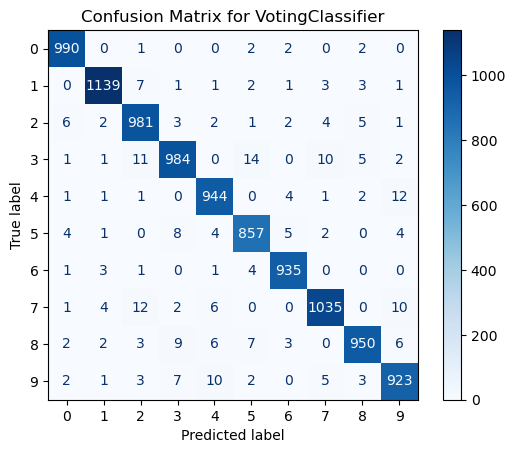

------------------------------------------------------------


In [21]:
# Train and evaluate 3 models using the Voting Classifer model (using scaled data)
# Define the models for the VotingClassifier (using scaler)
named_estimators_top3 = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf)
]

# Create the VotingClassifier
voting_clf = VotingClassifier(estimators=named_estimators_top3, voting='hard')

# Train and evaluate each model, including the VotingClassifier
for clf in [voting_clf]: 
    # Fit the model
    clf.fit(X_train_scaled, y_train)
    
    # Validate the model
    y_pred = clf.predict(X_val_scaled)
    score = clf.score(X_val_scaled, y_val)  # Compute accuracy
    
    # Print the model name and accuracy
    print(f"Model: {clf.__class__.__name__}, Accuracy: {score:.4f}")
    
    # Print the classification report
    print("Classification Report:")
    print(classification_report(y_val, y_pred))
    
    # Display the confusion matrix with the model name
    print("Confusion Matrix:")
    display_confusion_matrix(y_val, y_pred, clf.__class__.__name__)
    print("-" * 60)  # Separator for readability

# Summary

Summary of models sorted by best accuracy score

1. SVM 0.981 - 0.973
2. Voting Classifer with 3 models 97.38
3. ExtraTreesClassifier 0.9715
4. RandomForestClassifier 0.9692
5. Voting Classifier with 5 models 96.82
6. LogisticRegression 0.9099-0.9081
7. LinearSVC 0.8564 - 0.6889

Summary: The accuracy score for the SVM increased when I removed the scaler which is kind of odd since this model should perform better with 
normalized data. So the 97.3 is probably more accurate. However, given the small differences between the top 3 models I decided to continue with a model 
that is not relying on scaled data, easy to understand and more straightforward when it comes to preprocessing of input images. 
I decided to move forward with the Extra Trees Classifier model. 

# Evaluate best model on the test set. 

In [23]:
# Train Extra Trees on train+val dataset
extra_trees_clf.fit(X_train_val, y_train_val)

# Generate predictions on the test dataset
y_pred_test = extra_trees_clf.predict(X_test)

# Compute accuracy using the score() method
accuracy = extra_trees_clf.score(X_test, y_test)  # This directly computes accuracy
print(f"Accuracy using score(): {accuracy:.4f}")

Accuracy using score(): 0.9682


# Summary and analysis 

Evaluated 6 differente models/classifiers and two combinations when using the voting classifier.

Given small differences in accuracy score for the top 3 models, I decided to move forward with a model that is not using scaler, is easy to understand,
and is more straightforward when it comes to preprocessing of inpu timages. I selected the Extra Trees Classifier model. 
The model had an accuracy score of 97.15% on training data. 

Tested this model on the testing data with an accuracy score of 96.82%

# Save trained models

In [28]:
# saving the selected model

import joblib

joblib.dump(extra_trees_clf, "extra_trees_clf.pkl") 

['extra_trees_clf.pkl']

# Preprocessing of input images
Grayscale Conversion:
If the image has three channels (color), it is converted to grayscale using cv2.cvtColor(image, cv2.COLOR_BGR2GRAY). This results in a 2D matrix where pixel values represent grayscale intensity.

Thresholding:
Otsu's thresholding is applied to convert the grayscale image into a binary image. This method automatically determines an optimal threshold, turning pixels below the threshold white (255) and those above it black (0). This helps isolate digits from the background.

Resizing:
The binary image is resized directly to 28x28 pixels using inter-area interpolation, ensuring a consistent input size for the model.

Inversion:
The colors are inverted so that the background is black and the digits are white, ensuring consistency with the MNIST dataset.

Flattening:
The processed image is flattened into a 1D array of 784 elements (28x28), as required by the model.

Normalization (if applicable):
The pixel values are converted to float32, but no explicit normalization (e.g., mean 0, variance 1) is applied in the current code. If needed, normalization should be added before feeding the data into the model.

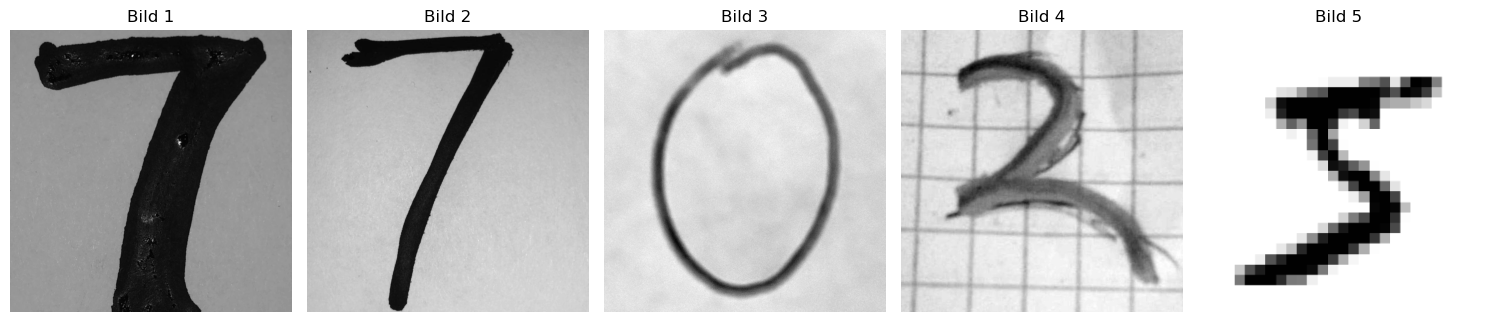

In [33]:
# I decided to evaluate the preprocessing steps on a sample of 5 digital images
image_paths = [
    "C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7.jpg",
    "C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7b.jpg",
    "C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit0.jpg",
    "C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit2.jpg",
    "C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit5.png"
]

# Antal bilder
num_images = len(image_paths)

# Skapa en figur för flera delplottar
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # 1 rad, flera kolumner

for i, image_path in enumerate(image_paths):
    # Läs in bilden
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        # Visa bilden i respektive subplot
        axes[i].imshow(image, cmap="gray")
        axes[i].set_title(f"Bild {i + 1}")
        axes[i].axis("off")  # Dölj axlar
    else:
        print(f"Bilden på {image_path} kunde inte laddas.")

# Visa alla bilder
plt.tight_layout()
plt.show()

Processing: C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7.jpg


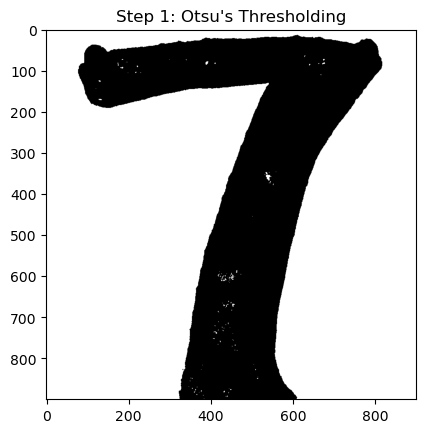

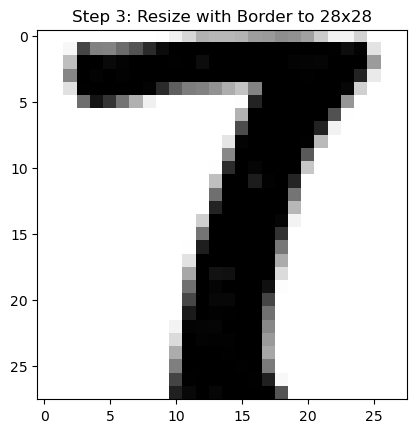

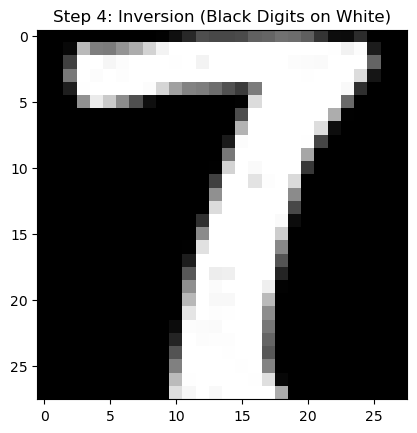

Preprocessed image for C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7.jpg is ready.
Processing: C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7b.jpg


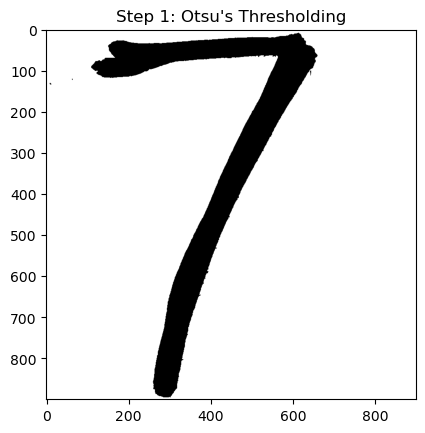

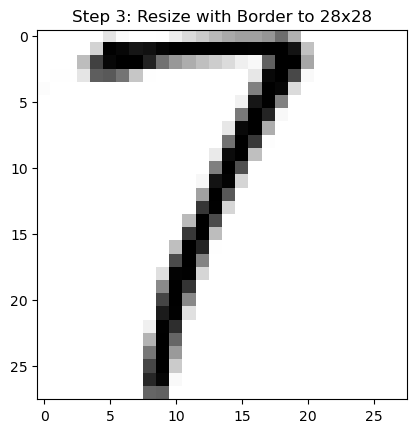

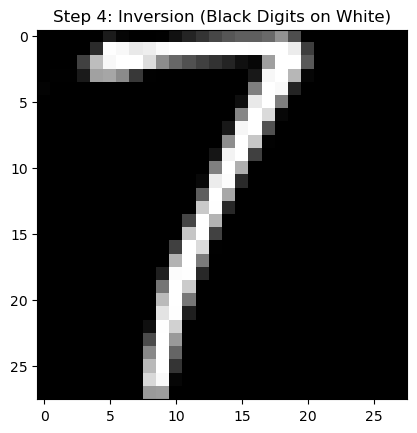

Preprocessed image for C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7b.jpg is ready.
Processing: C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit0.jpg


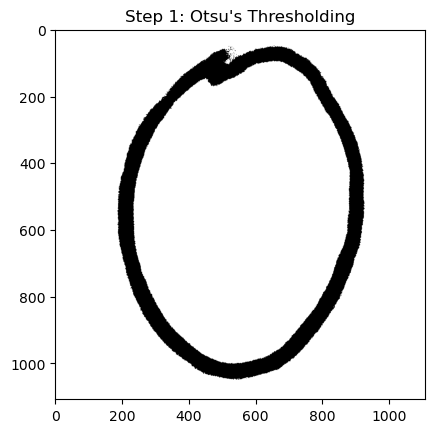

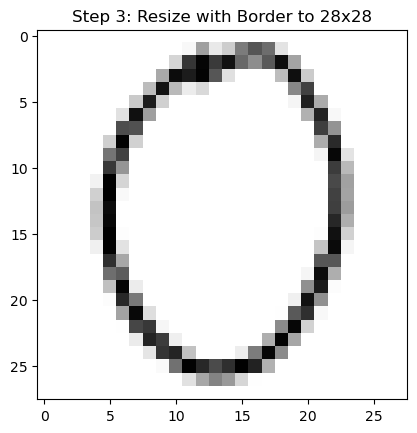

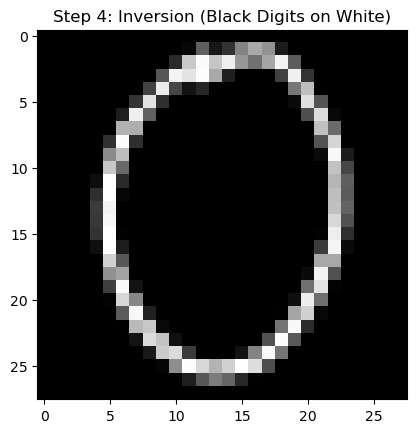

Preprocessed image for C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit0.jpg is ready.
Processing: C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit2.jpg


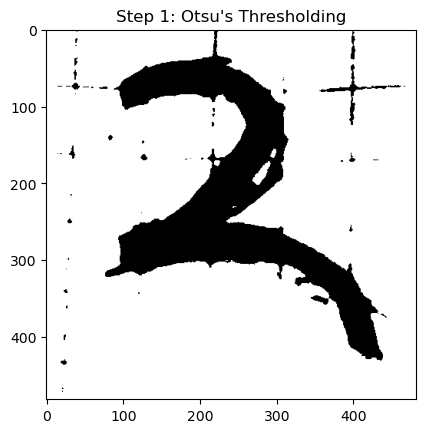

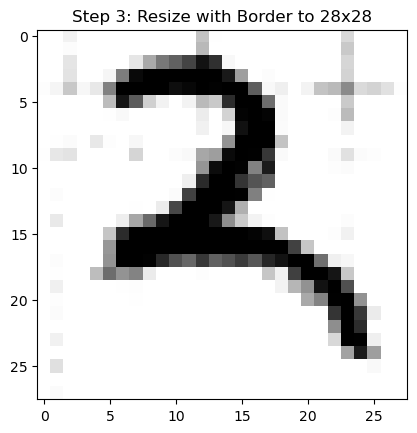

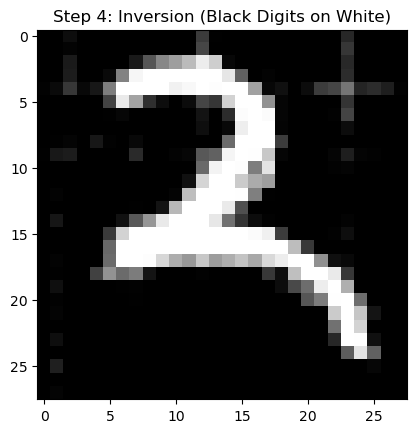

Preprocessed image for C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit2.jpg is ready.
Processing: C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit5.png


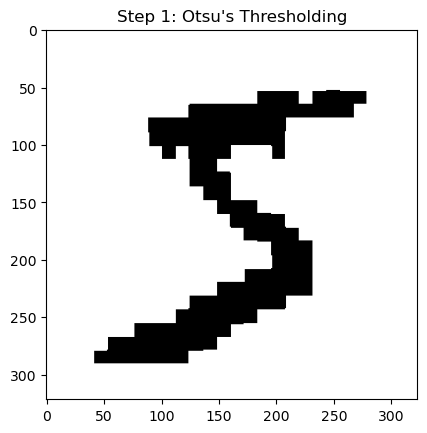

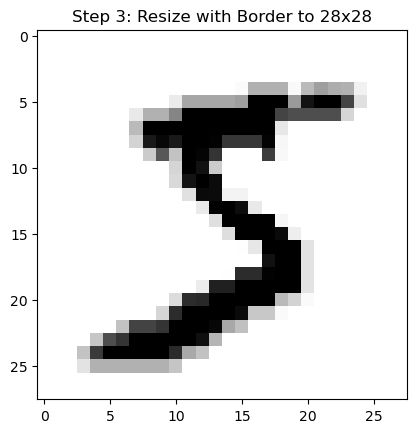

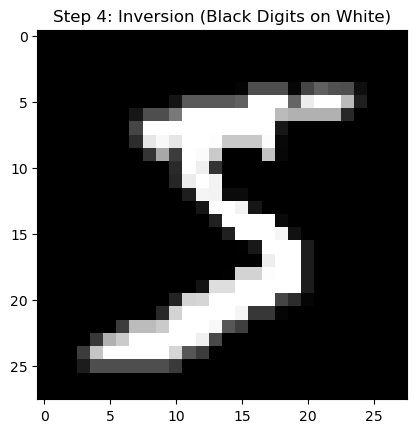

Preprocessed image for C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit5.png is ready.


In [56]:
# Preprocessing step by step using adaptive threshold using OTSU and ADAPTIVE

import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_and_display_image(image_path, use_adaptive_threshold=False):
    # Read the image and convert it to grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return None
    
    # Step 1: Apply Thresholding
    if use_adaptive_threshold:
        # Adaptive Thresholding (for uneven lighting)
        thresholded_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                                  cv2.THRESH_BINARY, 11, 2)
        method = "Adaptive Thresholding"
    else:
        # Otsu's Thresholding (automatic optimal threshold)
        _, thresholded_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        method = "Otsu's Thresholding"

    plt.imshow(thresholded_image, cmap='gray')
    plt.title(f"Step 1: {method}")
    plt.show()

     # Step 3: Resize with border to 28x28
    image_resized = cv2.resize(thresholded_image, (28, 28), interpolation=cv2.INTER_AREA)
    
    plt.imshow(image_resized, cmap='gray')
    plt.title("Step 3: Resize with Border to 28x28")
    plt.show()

    # Step 4: Inversion (black digits on white background)
    inverted_image = 255 - image_resized
    plt.imshow(inverted_image, cmap='gray')
    plt.title("Step 4: Inversion (Black Digits on White)")
    plt.show()

    # Step 5: Flattening (convert to 1D array)
    flat_image = inverted_image.flatten()
    
    return flat_image.reshape(1, -1)  # Return as 1D array for the model

    

# Example usage with your image paths
image_paths = [
    "C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7.jpg",
    "C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7b.jpg",
    "C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit0.jpg",
    "C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit2.jpg",
    "C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit5.png"
]

# Load the scaler
scaler = StandardScaler()

# Process each image and show the steps
for image_path in image_paths:
    print(f"Processing: {image_path}")
    preprocessed_image = preprocess_and_display_image(image_path)

    if preprocessed_image is not None:
        print(f"Preprocessed image for {image_path} is ready.")


Processing: C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7.jpg


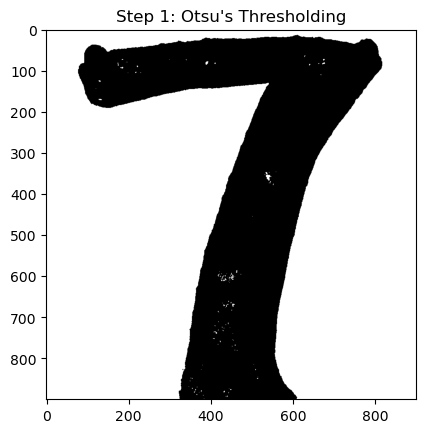

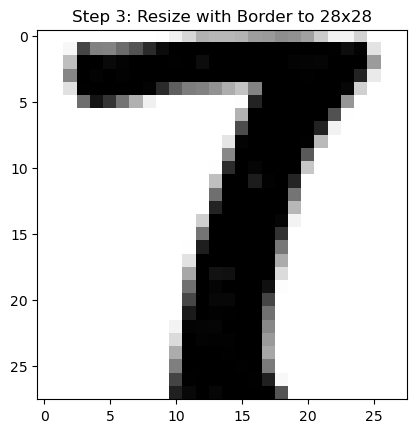

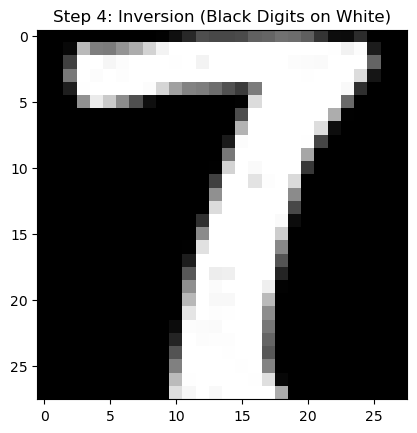

Preprocessed image for C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7.jpg is ready.
Processing: C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7b.jpg


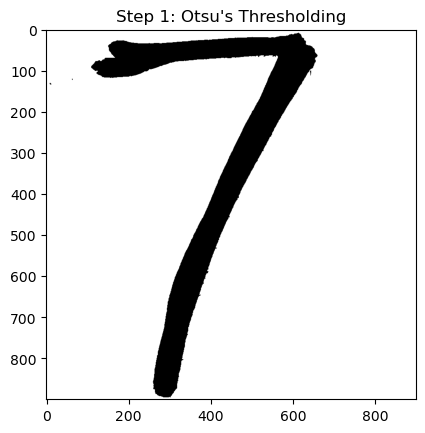

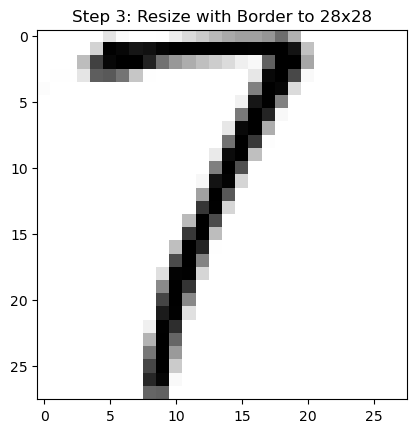

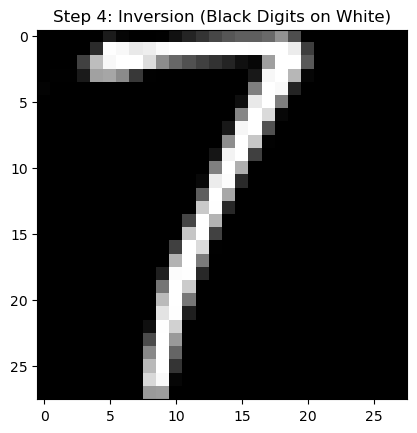

Preprocessed image for C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7b.jpg is ready.
Processing: C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit0.jpg


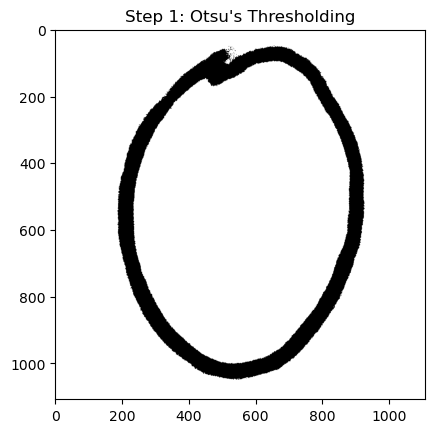

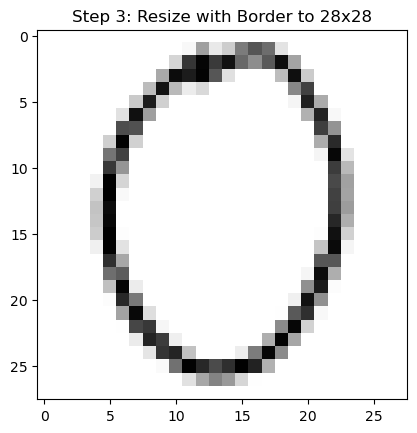

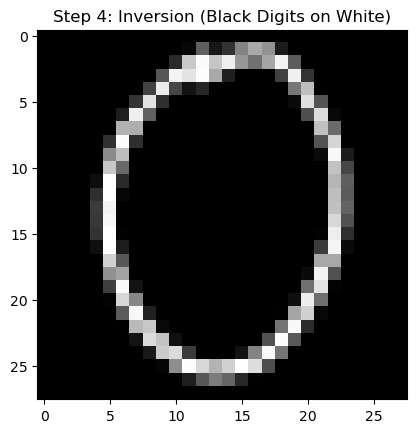

Preprocessed image for C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit0.jpg is ready.
Processing: C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit2.jpg


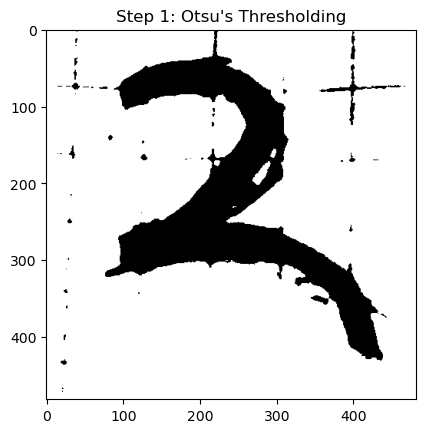

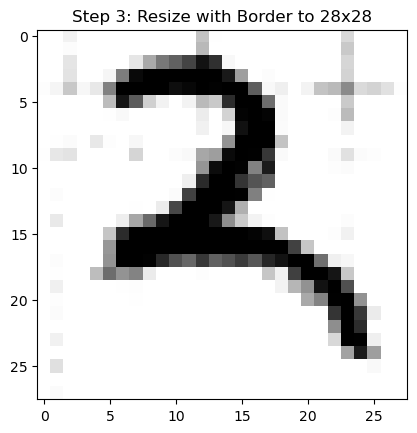

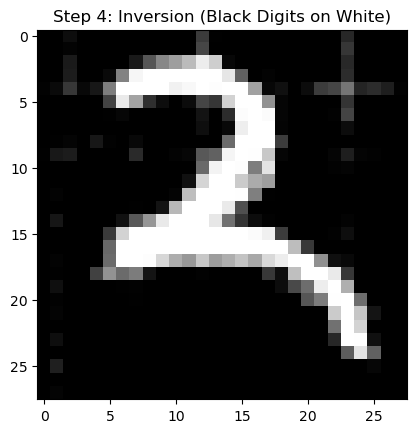

Preprocessed image for C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit2.jpg is ready.
Processing: C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit5.png


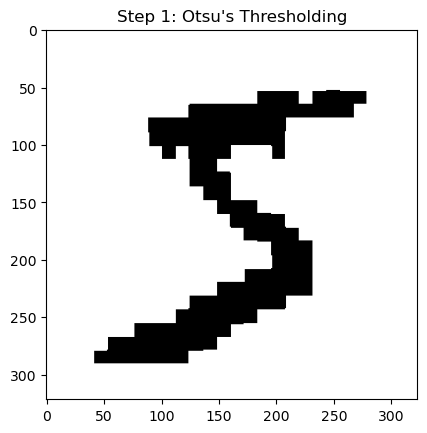

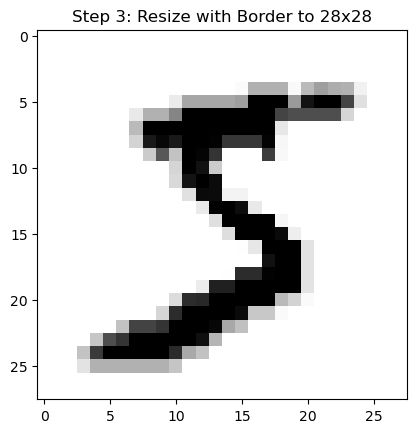

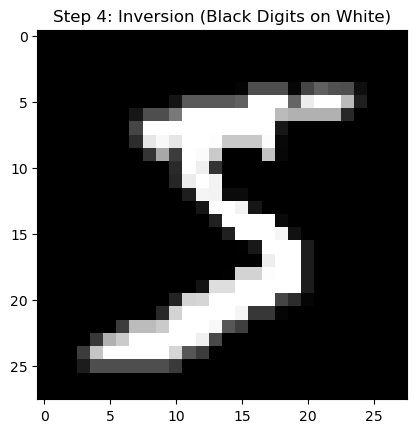

Preprocessed image for C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit5.png is ready.


In [57]:
# Preprocessing step by step using adaptive threshold using OTSU 

import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_and_display_image(image_path):
    # Read the image and convert it to grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return None
    
    # Step 1: Otsu's Thresholding (automatically finds the best threshold)
    _, thresholded_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    plt.imshow(thresholded_image, cmap='gray')
    plt.title("Step 1: Otsu's Thresholding")
    plt.show()

     # Step 3: Resize with border to 28x28
    image_resized = cv2.resize(thresholded_image, (28, 28), interpolation=cv2.INTER_AREA)
    
    plt.imshow(image_resized, cmap='gray')
    plt.title("Step 3: Resize with Border to 28x28")
    plt.show()

    # Step 4: Inversion (black digits on white background)
    inverted_image = 255 - image_resized
    plt.imshow(inverted_image, cmap='gray')
    plt.title("Step 4: Inversion (Black Digits on White)")
    plt.show()

    # Step 5: Flattening (convert to 1D array)
    flat_image = inverted_image.flatten()
    
    return flat_image.reshape(1, -1)  # Return as 1D array for the model
    

# Example usage with your image paths
image_paths = [
    "C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7.jpg",
    "C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7b.jpg",
    "C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit0.jpg",
    "C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit2.jpg",
    "C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit5.png"
]

# Load the scaler
scaler = StandardScaler()

# Process each image and show the steps
for image_path in image_paths:
    print(f"Processing: {image_path}")
    preprocessed_image = preprocess_and_display_image(image_path)

    if preprocessed_image is not None:
        print(f"Preprocessed image for {image_path} is ready.")


Processing: C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7.jpg


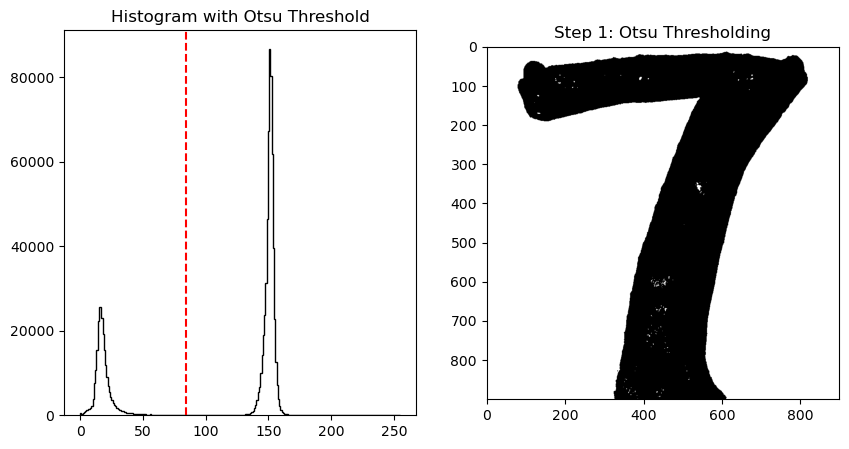

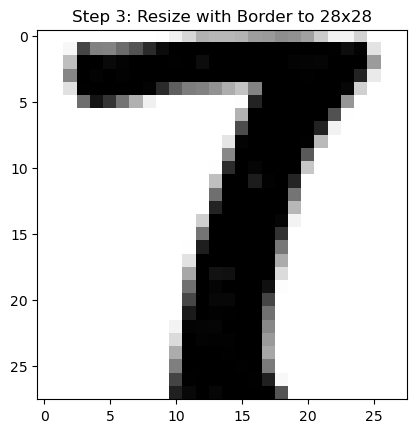

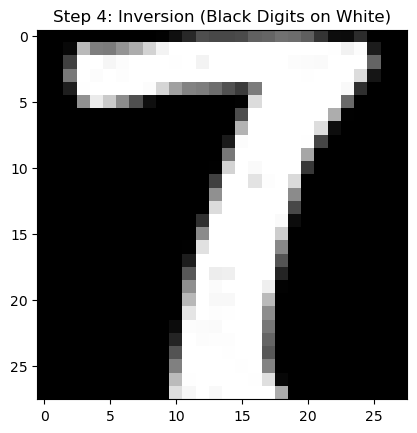

Preprocessed image for C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7.jpg is ready.
Processing: C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7b.jpg


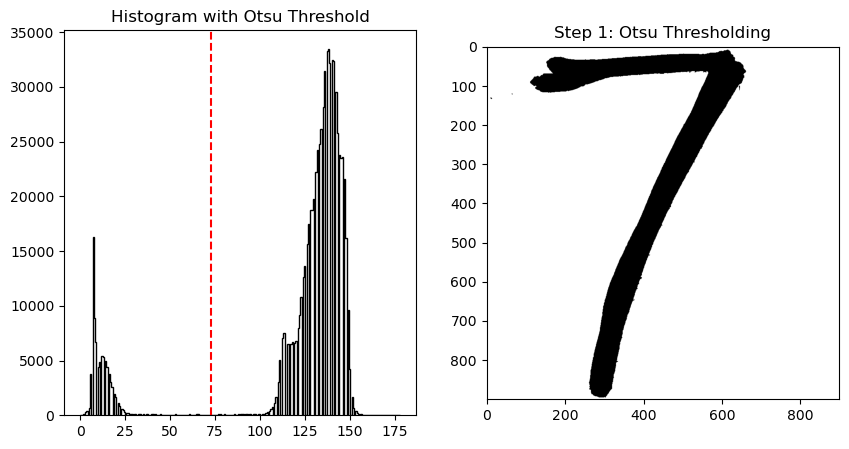

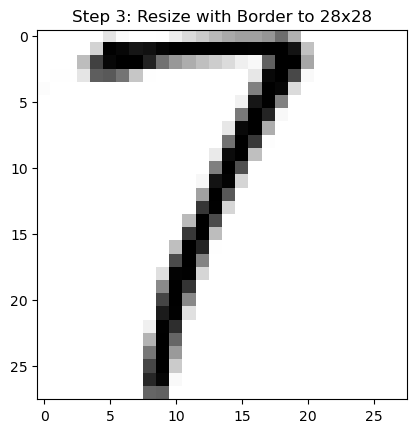

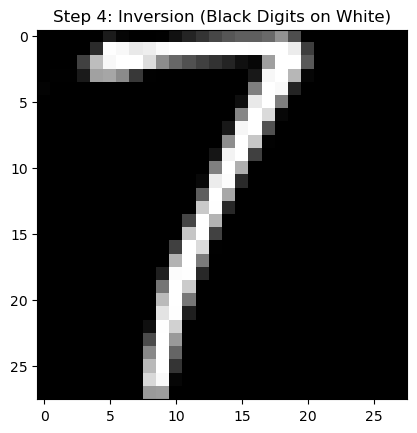

Preprocessed image for C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7b.jpg is ready.
Processing: C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit0.jpg


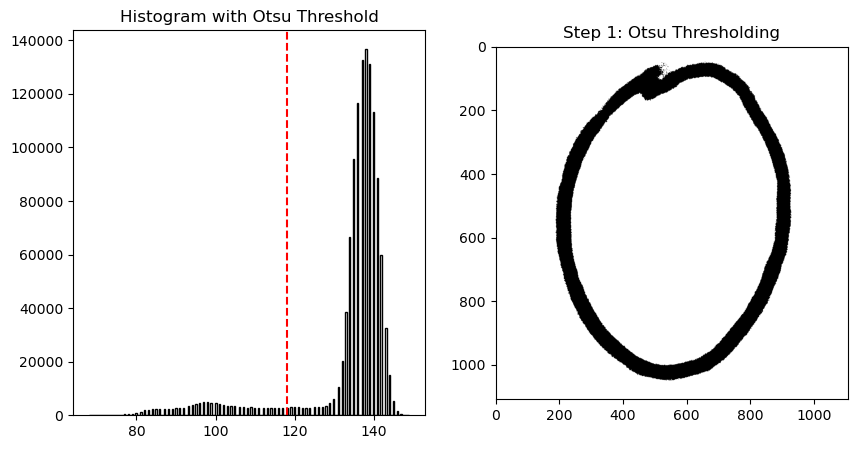

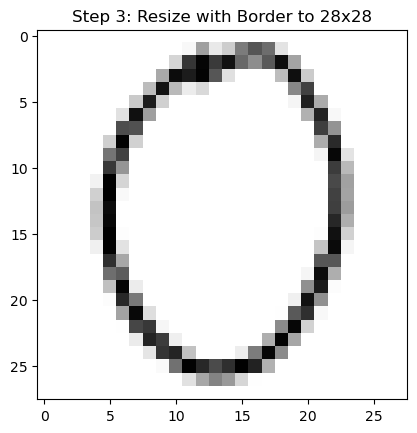

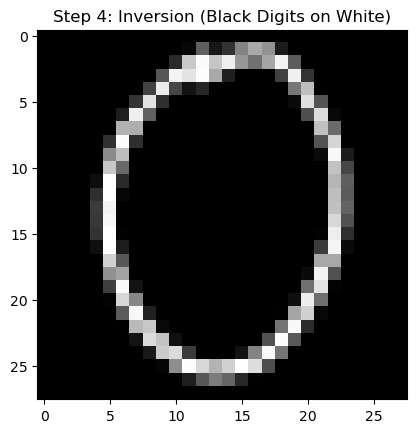

Preprocessed image for C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit0.jpg is ready.
Processing: C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit2.jpg


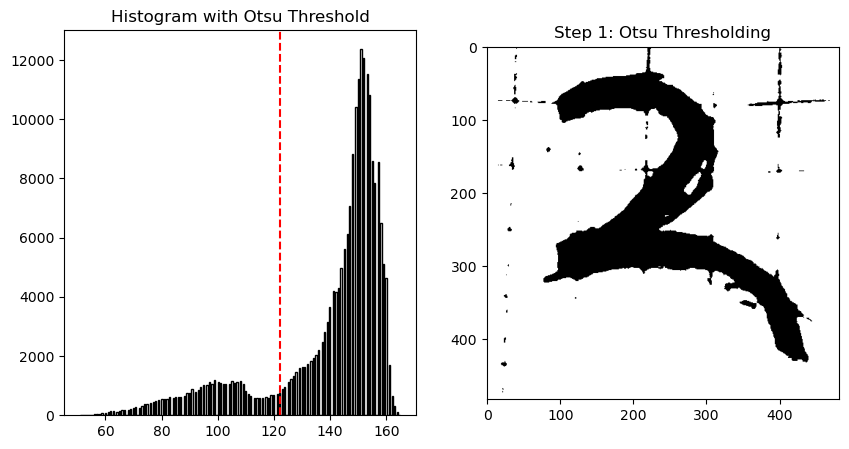

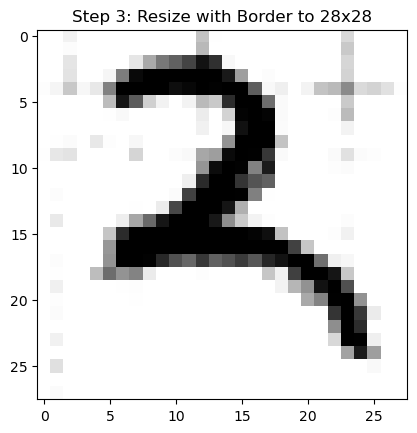

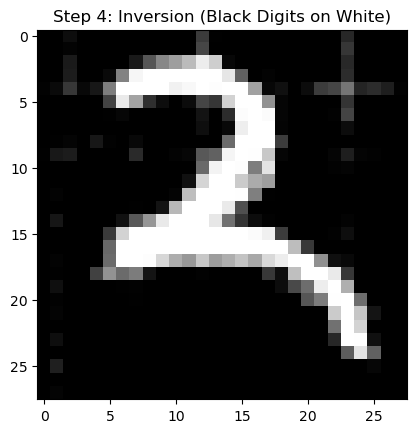

Preprocessed image for C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit2.jpg is ready.
Processing: C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit5.png


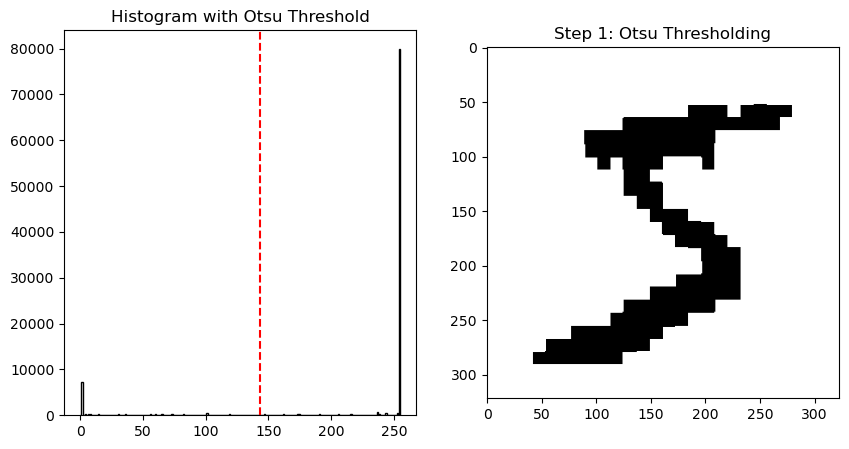

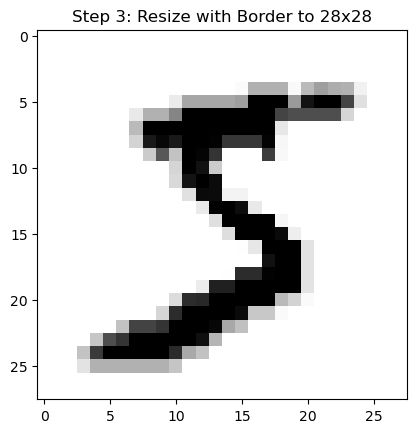

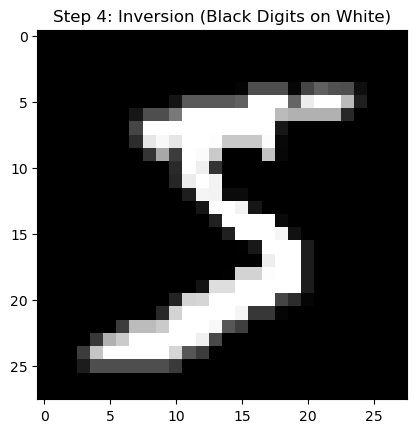

Preprocessed image for C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit5.png is ready.


In [51]:
# Preprocessing step by step using adaptive threshold using OTSU/HISTOGRAM

import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_and_display_image(image_path):
    # Read the image and convert it to grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return None
    
    # Step 1: Histogram-based thresholding (Otsu's method)
    # Otsu's method automatically finds the optimal threshold value
    _, thresholded_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Display the histogram and the thresholded image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(image.ravel(), bins=256, histtype='step', color='black')
    plt.axvline(x=_, color='red', linestyle='--')  # Threshold value from Otsu's method
    plt.title('Histogram with Otsu Threshold')
    plt.subplot(1, 2, 2)
    plt.imshow(thresholded_image, cmap='gray')
    plt.title("Step 1: Otsu Thresholding")
    plt.show()

    # Step 3: Resize with border to 28x28
    image_resized = cv2.resize(thresholded_image, (28, 28), interpolation=cv2.INTER_AREA)
    
    plt.imshow(image_resized, cmap='gray')
    plt.title("Step 3: Resize with Border to 28x28")
    plt.show()

    # Step 4: Inversion (black digits on white background)
    inverted_image = 255 - image_resized
    plt.imshow(inverted_image, cmap='gray')
    plt.title("Step 4: Inversion (Black Digits on White)")
    plt.show()

    # Step 5: Flattening (convert to 1D array)
    flat_image = inverted_image.flatten()
    
    return flat_image.reshape(1, -1)  # Return as 1D array for the model
    

# Example usage with your image paths
image_paths = [
    "C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7.jpg",
    "C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7b.jpg",
    "C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit0.jpg",
    "C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit2.jpg",
    "C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit5.png"
]

# Load the scaler
scaler = StandardScaler()

# Process each image and show the steps
for image_path in image_paths:
    print(f"Processing: {image_path}")
    preprocessed_image = preprocess_and_display_image(image_path)

    if preprocessed_image is not None:
        print(f"Preprocessed image for {image_path} is ready.")


# Predict preprocessed images using saved model

Model loaded successfully.


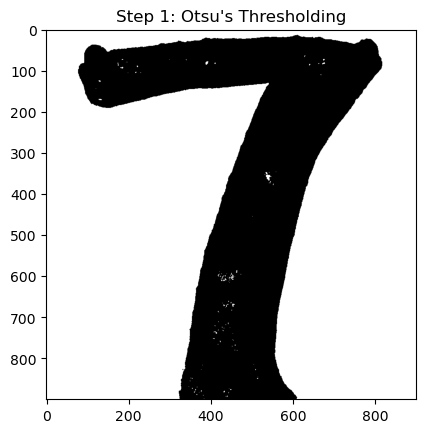

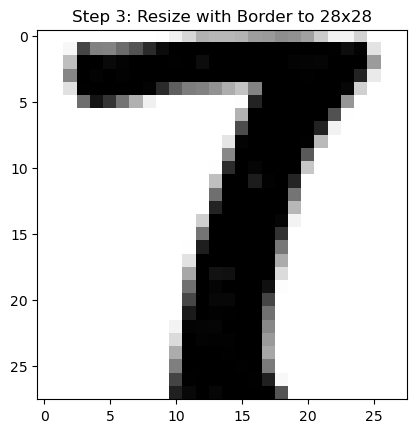

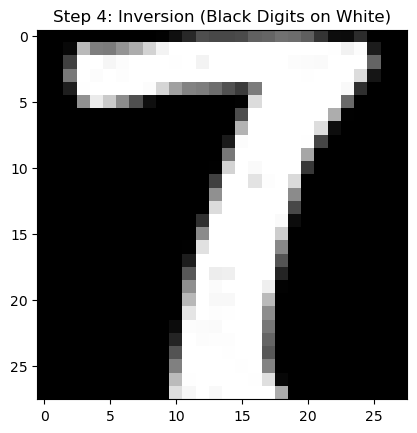

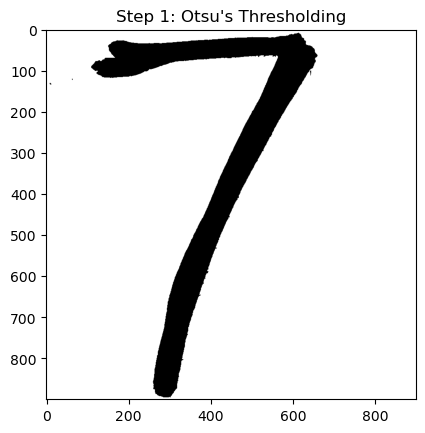

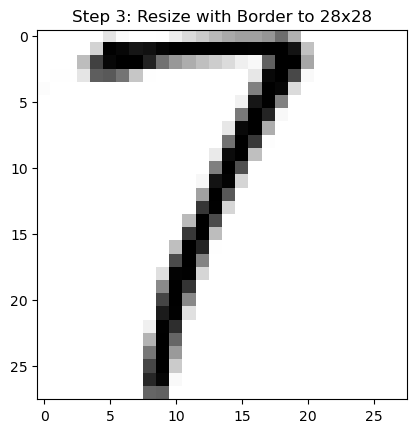

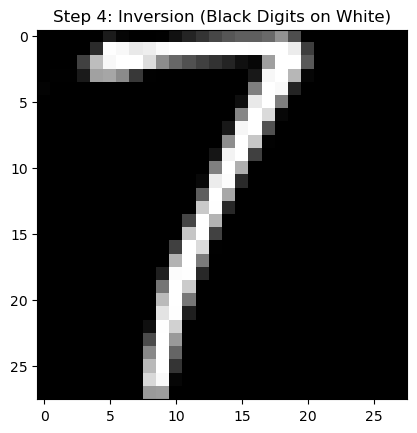

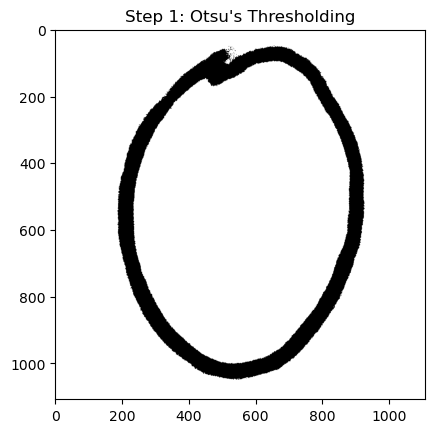

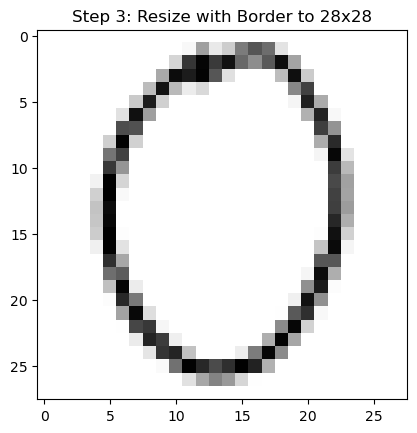

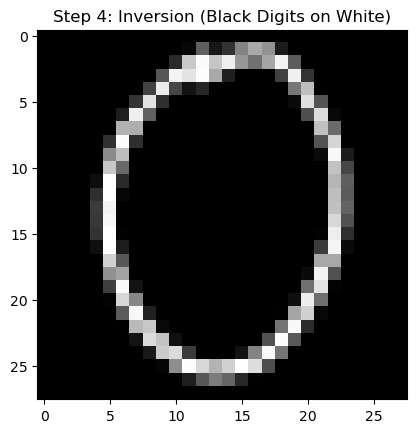

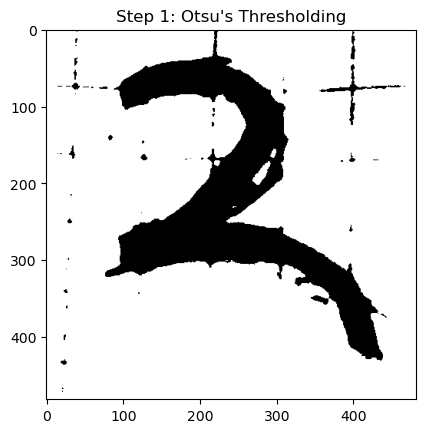

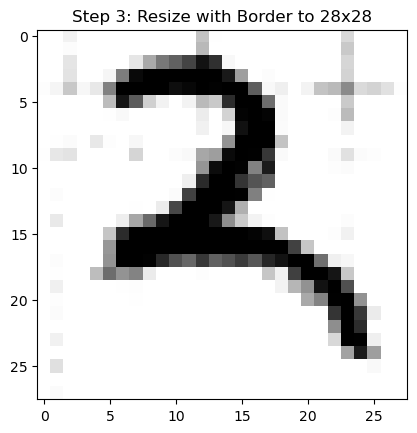

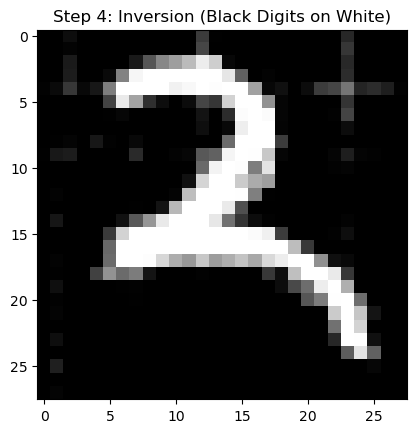

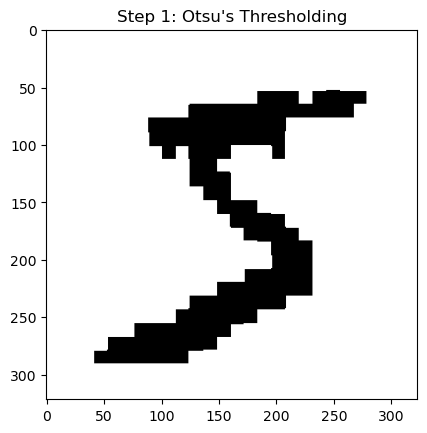

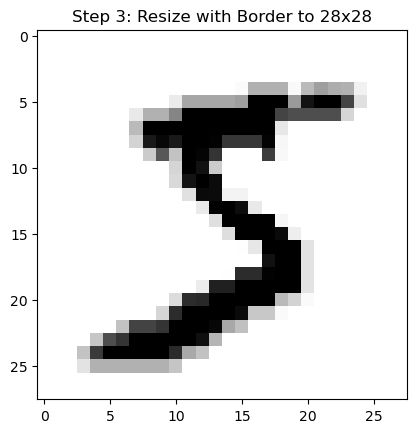

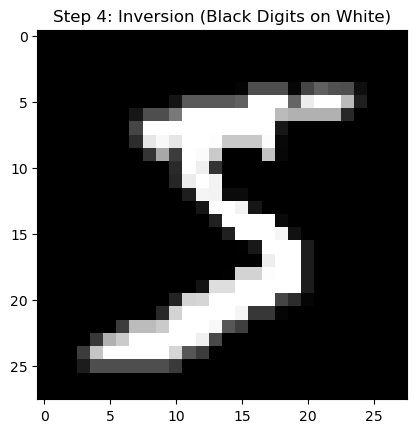

Prediction for C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7.jpg: 7
Prediction for C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit7b.jpg: 6
Prediction for C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit0.jpg: 0
Prediction for C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit2.jpg: 2
Prediction for C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/handwritten_digit5.png: 5


In [62]:
# Predict preprocessed images (using previous code) using OTSU/HISTOGRAM
import joblib  # For loading the trained model
import warnings

# Suppress specific sklearn warnings
warnings.filterwarnings("ignore", message=".*X does not have valid feature names.*")

# Paths to your trained voting classifier model and scaler
model_path = r"C:/Users/bjorn/Documents/Education/02_Artificiell_Intelligens/extra_trees_clf.pkl"

# Load the trained voting classifier model
try:
    mnist_voting = joblib.load(model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()


# Make predictions
predictions = []
for image_path in image_paths:
    processed_image = preprocess_and_display_image(image_path)
    
    if processed_image is None:
        continue

    try:
        prediction = extra_trees_clf.predict(processed_image)
        predictions.append((image_path, prediction[0]))
    except Exception as e:
        print(f"Error predicting image {image_path}: {e}")

# Output results
for image_path, prediction in predictions:
    print(f"Prediction for {image_path}: {prediction}")
